## Image segmentation with polyDataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.torch_basics import *
import os
from pathlib import Path
import torch
import numpy as np
import pandas as pd

#### Sample dataset to look into the functionalities of fastai2

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

(#4) [Path('/home/saruarlive/.fastai/data/camvid/valid.txt'),Path('/home/saruarlive/.fastai/data/camvid/codes.txt'),Path('/home/saruarlive/.fastai/data/camvid/labels'),Path('/home/saruarlive/.fastai/data/camvid/images')]

In [4]:
fnames = get_image_files(path/'images')
def label_func(x): return path/'labels'/f'{x.stem}_P{x.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes)

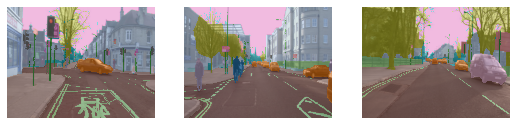

In [5]:
dls.show_batch(nrows=1, ncols=3)

In [6]:
# path_lbl = path/'labels'
# path_img = path/'images'

### Setting the path of polypData that we are going to segment

In [7]:
path = Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG') 
path.ls()
#print(path)

(#14) [Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/testmaskimages_cmix'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/.ipynb_checkpoints'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/kavsir_bboxes.json'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/.DS_Store'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/testimages'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/codes.txt'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1SSize'),Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/models')...]

In [8]:
path_img = path/'images'
path_lbl = path/'bmasks1'
# path_img = path/'imagesSSize'
# path_lbl = path/'bmasks1SSize'

### Data (images/masks) listing

In [9]:
fnames = sorted(get_image_files(path_img))
fnames[:3]

[Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg')]

In [10]:
lbl_names = sorted(get_image_files(path_lbl))
lbl_names[:3]

[Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qkwl35piu0993l0dewei2_b.png'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qoxqj9q6s0835b43399p4_b.png'),
 Path('/home/saruarlive/MyProjects/fastaiv19/Kvasir-SEG/bmasks1/cju0qx73cjw570799j4n5cjze_b.png')]

In [11]:
codes = np.array(['Background','Polypblob']); codes

array(['Background', 'Polypblob'], dtype='<U10')

## Datasets, creating a dataloader for segmenataion using fastai2

In [12]:
! nvidia-smi

Fri Oct 30 20:51:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:09:00.0 Off |                  N/A |
| 64%   82C    P2   273W / 280W |  13162MiB / 24220MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:42:00.0 Off |                  N/A |
| 41%   

(<AxesSubplot:>, <AxesSubplot:>)

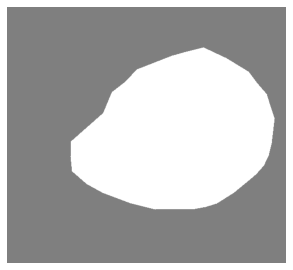

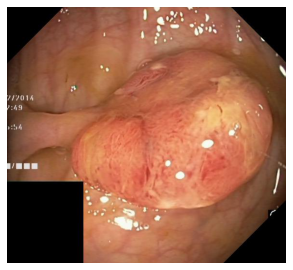

In [13]:
fnames = get_image_files(path/'images')
poly_fn = fnames[0]
mask_fn = path/'bmasks1'/f'{poly_fn.stem}_b.png'

poly_img = PILImage.create(poly_fn)
#test_eq(poly_img.size, (128,96))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
#test_eq(mask.size, (128,96))
mask.show(cmap='gray'), poly_img.show()

In [14]:
### Fastai2 dataloader
fnames = get_image_files(path/'images')
#def label_func(x): return path/'labels'/f'{x.stem}_b{x.suffix}'
label_func = lambda o: path/'bmasks1'/f'{o.stem}_b.png'
codes = np.array(['Background','Polypblob']);  ###method=ResizeMethod.Squish  item_tfms=Resize(128)
item_tfms  = [Resize(256, method=ResizeMethod.Squish)]  #### method='crop'
batch_tfms = [*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, valid_pct=0.2, codes=codes, item_tfms=item_tfms, batch_tfms=batch_tfms, bs=32)

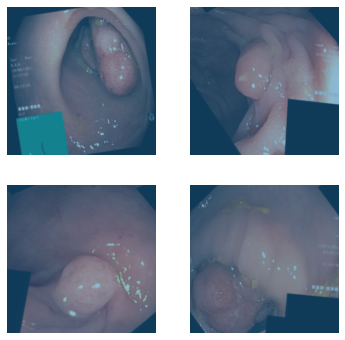

In [15]:
dls.show_batch(max_n=4)

### looking inside the dataloader 

In [16]:
#n_out = get_c(dls)
dls.one_batch()[0].shape, dls.one_batch()[0].unique(), dls.one_batch()[0].dtype, dls.one_batch()[0].min(), dls.one_batch()[0].max(), dls.one_batch()[1].shape, dls.one_batch()[1].unique(), dls.one_batch()[1].dtype

(torch.Size([32, 3, 256, 256]),
 TensorImage([-2.1179, -2.1179, -2.1179,  ...,  2.6400,  2.6400,  2.6400],
        device='cuda:0'),
 torch.float32,
 TensorImage(-2.1179, device='cuda:0'),
 TensorImage(2.6400, device='cuda:0'),
 torch.Size([32, 256, 256]),
 TensorMask([0, 1], device='cuda:0'),
 torch.int64)

In [17]:
dls.one_batch()

(TensorImage([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
        

### Training a model from fastai2

In [18]:
#metrics=[acc,Dice(axis=1)]
#metrics=acc

#### Displaying testimages and corresponding segmented regions

In [19]:
def save_mask(filename, tensormask, spath):
    testsize=PILImage.create(filename).size  ###width, height
    imgg=Image.fromarray(tensormask.numpy().astype('uint8')*255)
    imgg=imgg.resize(testsize, resample=Image.NEAREST)
    spath1=spath/f'{filename.stem}_segoutput{filename.suffix}'   
    imgg.save(spath1)

### Using fastai2's cutmix method
https://arxiv.org/abs/1905.04899

In [20]:
#export
from torch.distributions.beta import Beta
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [21]:
cutmix = CutMix(alpha=1.)

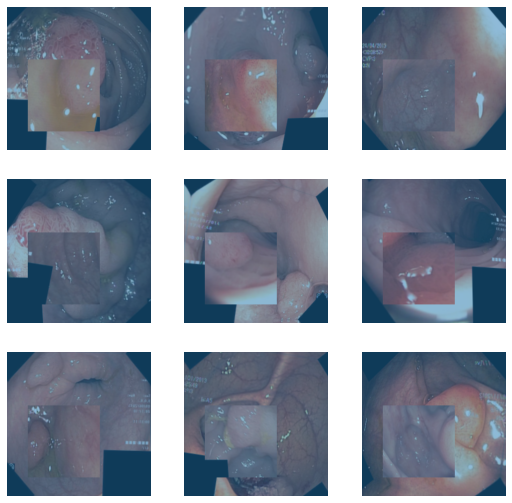

In [22]:
with Learner(dls, resnet34(), loss_func=CrossEntropyLossFlat(axis=1), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

(4.786300996784121e-05, 1.737800812406931e-05)

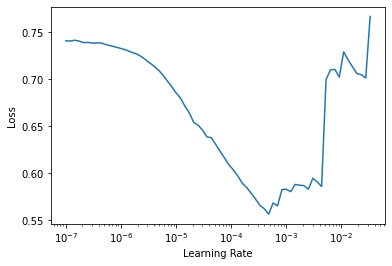

In [23]:
#cutmix = CutMix(alpha=1.)
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), cbs=cutmix, metrics=Dice(axis=1))
learn.freeze()
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [25]:
# lr=1e-04
# learnCM.fit_one_cycle(20, lr)
learn.unfreeze()
learn.fine_tune(120, freeze_epochs=20)

epoch,train_loss,valid_loss,dice,time
0,0.167411,0.130517,0.860499,00:31
1,0.193884,0.141703,0.852845,00:31
2,0.181578,0.131144,0.859464,00:31
3,0.179559,0.134456,0.862126,00:31
4,0.193806,0.137846,0.861187,00:31
5,0.183881,0.130240,0.864016,00:31
6,0.187517,0.132809,0.860967,00:31
7,0.195425,0.128816,0.857318,00:31
8,0.194972,0.142108,0.854398,00:31
9,0.190690,0.152509,0.818354,00:31


epoch,train_loss,valid_loss,dice,time
0,0.197129,0.144215,0.855178,00:32
1,0.199362,0.140679,0.859266,00:32
2,0.202563,0.140054,0.854360,00:32
3,0.187848,0.128669,0.868242,00:32
4,0.179200,0.132593,0.864725,00:32
5,0.187571,0.135281,0.865722,00:32
6,0.182960,0.127551,0.866217,00:32
7,0.186245,0.135591,0.858814,00:32
8,0.178690,0.129141,0.868763,00:32
9,0.178425,0.128820,0.866480,00:31


In [27]:
timages = sorted(get_image_files(path/'testimages'))
maskdir=path/'testmaskimages_cmix'

# for i, fpath in enumerate(timages):
#     tensormask=learn.predict(fpath)[0]
#     save_mask(fpath, tensormask, maskdir)

tt=learn.predict(timages[15])
#mtnsr=torch.add(tt[2][1,:,:], tt[0][0,:,:])
# tnsr=mtnsr.numpy().astype('int64')
# np.unique(tnsr)
#save_cmixmask(timages[10], tt[2][1,:,:], maskdir)
#np.sum(tnsr==5)
# tt[2][1,:,:].shape
# ttfill=torch.empty(256,256)
# for i in range(256):
#     for j in range(256):
#         if tt[2][1,i,j]>tt[2][0,i,j]:
#             ttfill[i,j]=1
#         elif tt[2][1,i,j]<=tt[2][0,i,j]:
#             ttfill[i,j]=1
#         else:
#             print('just do')   

In [31]:
tt=learn.predict(timages[15])
print(tt[0].shape, tt[1].shape, tt[2].shape)
tt

torch.Size([2, 256, 256]) torch.Size([2, 256, 256]) torch.Size([2, 256, 256])


(TensorMask([[[ 3.4512,  3.7648,  4.8309,  ...,  4.3966,  3.3230,  3.1817],
          [ 3.4074,  3.9261,  4.4212,  ...,  4.3434,  3.4921,  3.5464],
          [ 3.4284,  4.2890,  4.5556,  ...,  4.4926,  3.9719,  3.7626],
          ...,
          [ 3.2073,  3.9376,  4.0297,  ...,  4.3225,  3.9797,  3.4936],
          [ 3.1094,  3.7204,  4.0000,  ...,  3.9928,  3.5525,  3.0001],
          [ 2.3231,  3.0874,  3.3625,  ...,  3.4455,  3.0873,  2.4396]],
 
         [[-1.3106, -1.6256, -1.6847,  ..., -1.7499, -1.4720, -1.5663],
          [-1.5804, -1.7009, -1.7038,  ..., -1.8240, -1.5723, -1.8536],
          [-2.1167, -2.1542, -2.2181,  ..., -2.1904, -2.1333, -2.2366],
          ...,
          [-1.8759, -1.9530, -1.8910,  ..., -2.1399, -2.0717, -2.0120],
          [-1.7063, -1.8884, -1.9664,  ..., -1.9779, -1.8324, -1.6924],
          [-1.8951, -2.0246, -2.0611,  ..., -1.9492, -1.7637, -1.4994]]]),
 tensor([[[ 3.4512,  3.7648,  4.8309,  ...,  4.3966,  3.3230,  3.1817],
          [ 3.4074,  3.9

In [64]:
def save_cmixmask(filename, tensormask, spath):
    testsize=PILImage.create(filename).size  ###width, height
    imgg=Image.fromarray(tensormask.numpy().astype('uint8'))
    imgg=imgg.resize(testsize, resample=Image.NEAREST)
    spath1=spath/f'{filename.stem}_segoutput{filename.suffix}'   
    imgg.save(spath1)

RuntimeError: number of dims don't match in permute

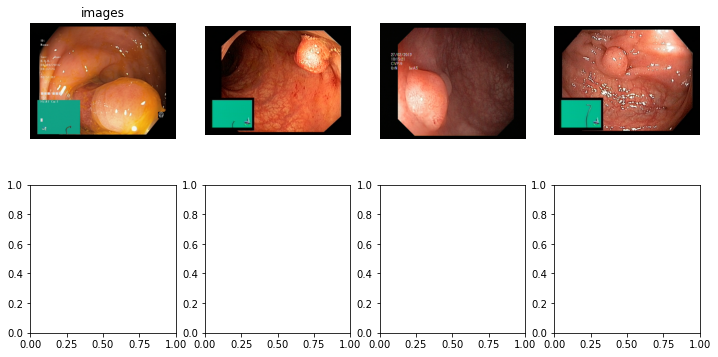

In [50]:
fnames = get_image_files(path/'testimages')
imgdicts={}
flist=[20, 40, 50, 60]
for i, img in enumerate(flist):
    imgdicts[0,i]=PILImage.create(fnames[img])
    imgdicts[1,i]=learnCM.predict(fnames[img])[1].unsqueeze(0) ###learnCM.predict(fnames[img])[2][1,:].unsqueeze(0)
show_images((imgdicts[0,0],imgdicts[0,1],imgdicts[0,2],imgdicts[0,3],imgdicts[1,0],imgdicts[1,1],imgdicts[1,2],imgdicts[1,3]), titles=('images','','','', 'output', '','','',), nrows=2, ncols=4)